## Imports

In [1]:
from pathlib import Path
import json
from collections import defaultdict

In [2]:
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytesseract as tess
from PIL import Image
from sklearn.cluster import DBSCAN

## Constants

In [3]:
TESS_SCALE = 5
DATA_DIR = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")  # C:\datasets\pubtabnet
TEST_DIR = DATA_DIR / "train"

# Used for drawing boxes
COLORS = {
    'black':(0,0,0),
    'red':(150,0,0),
    'green':(0,150,0),
    'blue':(0,0,150)
}

FORMAT_CHARS = [
    '<b>',
    '</b>',
    '<i>',
    '</i>',
    '<sup>',
    '</sup>',
    '<sub>',
    '</sub>',
]

## Image Utils

Functions:
* `scale(im, scale)`: used to scale images (needed for accurate results from tesseract)
* `draw(im, bbox, fmt='cv2', color='black')`: draws a rectangle

In [61]:
def scale(im, scale):
    return im.resize((int(x*scale) for x in im.size))

def draw(im, bbox, fmt='cv2', color='black'):
    im = np.array(im)  # in case it is in PIL format
    if fmt=='cv2':
        x,y,w,h = bbox
    elif fmt == 'pil':
        x1,y1,x2,y2 = bbox
        x,y,w,h = x1,y1,x2-x1,y2-y1
    
    W,H,_ = im.shape
    
    if isinstance(color, str):
        color = COLORS[color]
    
    pt1 = (x, y)
    pt2 = (x+w, y+h)
    return cv2.rectangle(im, pt1=pt1, pt2=pt2,
        color=color, thickness=1
    )

## Load Data

In [5]:
files = list(TEST_DIR.glob("*.png"))

In [6]:
with open(DATA_DIR / "PubTabNet_2.0.0.jsonl", "r", encoding="utf8") as f:
    json_list = list(f)

In [7]:
fname_index_map = {}

for i, json_str in enumerate(json_list):
    result = json.loads(json_str)
    fname_index_map[result["filename"]] = i

## Data Utils
Utility functions for interacting with the PubTabNet Dataset


Functions:
* `X(i)`: returns the i'th image as a PIL.Image object
* `Y(i)`: returns the i'th json object (dict) representing the target of our model
* `get_data(i)`: similar to `Y(i)` but in dataframe format

In [8]:
def Y(i):
    fname = files[i]
    i = fname_index_map[fname.parts[-1]]
    return json.loads(json_list[i])

def X(i):
    return Image.open(files[i])

In [9]:
def html_iterator(y):
    html = y['html']['structure']['tokens']
    
    row = 0
    column = 0
    is_head = False
    is_body = False
    row_start=None
    row_end=None
    col_start=0
    col_end=0
    raw = ''
    
    for t in html:
        raw += t
        if '<td' in t:
            col_start = column
        
        elif t == '</td>':
            col_end = column
            row_end = row
            column += 1
            yield {
                'col_start':col_start,
                'col_end':col_end,
                'row_start':row_start,
                'row_end':row_end,
                'is_head':is_head,
                'is_body':is_body,
                'raw': raw,
            }
            raw = ''
            
        elif t == '<thead>':
            row_start = row
            is_head = True
            
        elif t == '</thead>':
            is_head = False
            
        elif t == '<tr>':
            row_start = row
            
        elif t == '</tr>':
            column = 0
            row += 1
            
        elif "colspan" in t:
            # extract the int from the string and increment the row counter
            column += int(t.split('"')[1]) - 1
        
        elif t == '<tbody>':
            is_body = True
            
        elif t == '</tbody>':
            is_body = False
            
        elif t in ['>']:
            pass
        
        else:
            raise ValueError(t)

In [10]:
def clean_text(cell):
    text = ''.join(cell["tokens"]).strip()
    for fmt in FORMAT_CHARS:
        text = text.replace(fmt, '')
    return text

In [64]:
def get_data(i):
    data = Y(i)
    struct = html_iterator(data)
    
    rows = []
    for cell in data['html']['cells']:
        cell_data = next(struct)
        if 'bbox' in cell:
            cell_data['text'] = clean_text(cell),
            cell_data['bbox'] = cell["bbox"]
            rows.append(cell_data)
            
    df = pd.DataFrame(rows)
    # pandas wants to convert the str to a tuple for some reason
    # so we force it back to a str here
    df['text'] = [x[0] for x in df['text']]
    return df

In [65]:
def display_ground_truth_bboxes(i):
    im = X(i)
    data = Y(i)
    bboxes = [x['bbox'] for x in data['html']['cells'] if 'bbox' in x]
    for bbox in bboxes:
        im = draw(im, bbox, fmt='pil', color='green')
    return Image.fromarray(im)

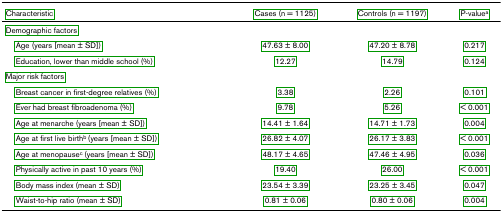

In [66]:
display_ground_truth_bboxes(1)

In [101]:
def make_smaller_dataset(start=0, limit=-1, outdir='.'):
    res = {}
    for fname in files[start:start+limit]:
        i = fname_index_map[fname.parts[-1]]
        data = json.loads(json_list[i])
        res[fname.name] = [x['bbox'] for x in data['html']['cells'] if 'bbox' in x]
    with open(f"{outdir}/{start}.json", 'w') as f:
        json.dump(res, f)

In [99]:
# start = 0
# limit = 10000
# N = len(files)
# outdir = "targets"
# Path(outdir).mkdir(exist_ok = True)
# while start<N:
#     make_smaller_dataset(start, limit, outdir)
#     start += limit

In [102]:
make_smaller_dataset()